## Convolutional Neural Network (CNN)

### Feature Extraction

<li>Each sound clip is divided into segments of 60x41 (60 rows and 41 columns). Two channels mel-spec and their deltas were fed into the CNN.</li>
<li>convolutional neural network with four layers with Relu activation function followed by two max pooling layers.</li>
<li>After two dens layers dropout layer followed by dense layer with softmax activation is added to output probabilities of the sound classes.</li>
<li>We will use Adam optimizer to minimize binary crossentropy loss to training the network.</li>

reference of feature extraction: http://aqibsaeed.github.io/2016-09-24-urban-sound-classification-part-2/

In [1]:
# Architecture of model
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://aqibsaeed.github.io/img/urban-sound-cnn.PNG",width=1000, height=1000)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import glob

In [4]:
def window(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += int(window_size / 2)

In [5]:
def extract_features(filename, bands = 60, frames = 41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    sound_clip,s = librosa.load(filename)        
    for (start,end) in window(sound_clip,window_size):
        start = int(start)
        end = int(end)
        if(len(sound_clip[start:end]) == window_size):
            signal = sound_clip[start:end]
            melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
            logspec = librosa.amplitude_to_db(melspec)
            logspec = logspec.T.flatten()[:, np.newaxis].T
            log_specgrams.append(logspec)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features)

### Test file

In [6]:
sample = os.path.join('data', 'physionet', 'training-a', 'a0001.wav')
features = extract_features(sample)
data_points, _ = librosa.load(sample)
print ("Data Points in sound file =", len(data_points))
print ("Total features '(total segments, rows, columns,channel)' =", np.shape(features))

Data Points in sound file = 786436
Total features '(total segments, rows, columns,channel)' = (75, 60, 41, 2)


<li>Its important to point out that this method outputs a feature representation bigger than the previous method used for the FFN. For the same file this method has reduced the input from 786436 features to 369000 compared to the previous 193 features. By having more information it is expected to have better results.</li>
<li>Here total segment in each wav. file changes according to file length, which increses the total data points, leading to more reference frames.</li>

In [7]:
def parse_files(subdirs):
    parent_dir = os.path.join('data', 'physionet')
    save_path = os.path.join('data', 'physionet', 'reduced_features')
    bands = 60
    frames = 41
    window_size = 512 * (frames - 1)
    for path, df_name in paths:
        log_specgrams = []
        labels = []
        csv_path = os.path.join(path, 'REFERENCE.csv')
        df = pd.read_csv(csv_path, names = ['fname', 'target'])
        df['fname'] = df['fname'].apply(lambda f: os.path.join(path,f + '.wav'))
        df['target'] = df['target'].apply(lambda x: 1 if x == -1 else 0)
        for index, row in df.iterrows():
            sound_clip,s = librosa.load(row['fname'])
            label = row['target']
            for (start,end) in window(sound_clip,window_size):
                if(len(sound_clip[start:end]) == int(window_size)):
                    signal = sound_clip[start:end]
                    melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                    logspec = librosa.amplitude_to_db(melspec)
                    logspec = logspec.T.flatten()[:, np.newaxis].T
                    log_specgrams.append(logspec)
                    labels.append(label)
        log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
        features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
        for i in range(len(features)):
            features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
        feature_file = os.path.join(save_path, df_name + '_cnn_x.npy')
        np.save(feature_file, np.array(features))
        feature_file = os.path.join(save_path, df_name + '_cnn_y.npy')
        np.save(feature_file, np.array(labels))

<li><font color=red>CNN is tested on subset of the parsed files in the repo in order to test, because complete dataset is large and takes more time.</font></li>

In [8]:
paths = [(os.path.join('data', 'physionet', 'training-c'), 'df_c')]

# Uncomment line below to parse all files.This will take a while :)

#paths = [(os.path.join('data', 'physionet', 'training-a'), 'df_a'),
#        (os.path.join('data', 'physionet', 'training-b'), 'df_b'),
#        (os.path.join('data', 'physionet', 'training-c'), 'df_c'),
#        (os.path.join('data', 'physionet', 'training-d'), 'df_d'),
#        (os.path.join('data', 'physionet', 'training-e'), 'df_e')]


parse_files(paths)

In [9]:
npfiles = [('df_c_cnn_x.npy','df_c_cnn_y.npy')]

# Uncomment below to load all feature files.
#npfiles = [('df_a_cnn_x.npy','df_a_cnn_y.npy'),
#           ('df_b_cnn_x.npy','df_b_cnn_y.npy'),
#           ('df_c_cnn_x.npy','df_c_cnn_y.npy'),
#           ('df_d_cnn_x.npy','df_d_cnn_y.npy'),
#           ('df_e_cnn_x.npy','df_e_cnn_y.npy')]

data_dir = os.path.join('data', 'physionet', 'reduced_features')

def load_npfiles(npfiles):
    concatenate = False
    for x, y in npfiles:
        print("Adding X:", x)
        loaded_features = np.load(os.path.join(data_dir, x))
        print("Shape X:", loaded_features.shape)

        print("Adding y:", y)
        loaded_labels = np.load(os.path.join(data_dir, y))
        print("Shape Y:", loaded_labels.shape)

        if concatenate:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            concatenate = True
    return features, labels
    
X, y = load_npfiles(npfiles)

Adding X: df_c_cnn_x.npy
Shape X: (3251, 60, 41, 2)
Adding y: df_c_cnn_y.npy
Shape Y: (3251,)


### Training

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [11]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
import keras.backend as K

def create_model(dropout_rate=0.5):
    frames = 41
    bands = 60
    feature_size = bands * frames
    num_channels = 2
    f_size = 1
    model = Sequential()
    model.add(Convolution2D(48, f_size, strides=f_size, kernel_initializer='normal', padding='same', input_shape=(bands, frames, num_channels)))
    model.add(Convolution2D(48, f_size, strides=f_size, kernel_initializer='normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(96, f_size, strides=f_size, kernel_initializer='normal', padding='same'))
    model.add(Convolution2D(96, f_size, strides=f_size, kernel_initializer='normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [12]:
model = create_model() # create model

In [13]:
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))

Train on 2438 samples, validate on 813 samples
Epoch 1/25
2438/2438 [==============================] - 10s 4ms/step - loss: 0.3587 - accuracy: 0.8060 - val_loss: 0.2847 - val_accuracy: 0.8303
Epoch 2/25
2438/2438 [==============================] - 9s 4ms/step - loss: 0.2888 - accuracy: 0.8249 - val_loss: 0.2613 - val_accuracy: 0.8573
Epoch 3/25
2438/2438 [==============================] - 9s 4ms/step - loss: 0.2519 - accuracy: 0.8679 - val_loss: 0.2156 - val_accuracy: 0.8893
Epoch 4/25
2438/2438 [==============================] - 9s 4ms/step - loss: 0.1638 - accuracy: 0.9282 - val_loss: 0.1634 - val_accuracy: 0.9422
Epoch 5/25
2438/2438 [==============================] - 9s 4ms/step - loss: 0.0982 - accuracy: 0.9623 - val_loss: 0.1038 - val_accuracy: 0.9533
Epoch 6/25
2438/2438 [==============================] - 9s 4ms/step - loss: 0.0907 - accuracy: 0.9696 - val_loss: 0.1124 - val_accuracy: 0.9533
Epoch 7/25
2438/2438 [==============================] - 9s 4ms/step - loss: 0.0680 - acc

In [14]:
# Uncomment to save weights
#model.save('models/cnn.hdf5')

### Results

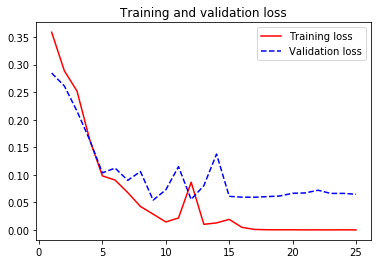

In [15]:
epochs = range(1, 26)
plt.figure()
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

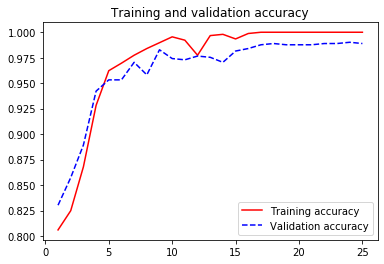

In [16]:
plt.figure()
plt.plot(epochs, history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b--', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

From the graphs we can observe that accuracy of the model does not increases after the 15th epoch.

In [17]:
# Uncomment to load weights
#model.load_weights('models/cnn.hdf5')

In [18]:
def evaluate(model, x_test, y_test):
    y_pred = model.predict_classes(x_test)
    
    score, accuracy = model.evaluate(x_test, y_test, batch_size=32)
    print('-'*50)
    
    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Precision:", p)
    print("Recall:", r)
    print("F1-Score:", f1)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
evaluate(model, x_test, y_test)

813/813 [==============================] - 1s 729us/step
--------------------------------------------------
Accuracy: 0.9889298677444458
Precision: 0.9708029197080292
Recall: 0.9637681159420289
F1-Score: 0.9672727272727273
Confusion Matrix:
[[671   4]
 [  5 133]]


### Refinement

As same as we did with the FFN to use GridSearch to find a set of hyperparameters that would generate the best model, we will use the same method with the CNN. Because of the time required to train the CNN in this part we will only experiment with the dropout rate. The same method can be applied to different parameters but it will require the signature of the function to create the model to match with what will be used in the GridSearch.

In [19]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=create_model)

dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]

param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1')

grid_result = grid.fit(x_train, y_train)

print("Best loss: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/1
1625/1625 [==============================] - 6s 4ms/step - loss: 0.3626 - accuracy: 0.8049
Epoch 1/1
1625/1625 [==============================] - 6s 4ms/step - loss: 0.3715 - accuracy: 0.8178
Epoch 1/1
1626/1626 [==============================] - 6s 4ms/step - loss: 0.3971 - accuracy: 0.8026
Epoch 1/1
1625/1625 [==============================] - 6s 4ms/step - loss: 0.3943 - accuracy: 0.7988
Epoch 1/1
1625/1625 [==============================] - 6s 4ms/step - loss: 0.4146 - accuracy: 0.8086
Epoch 1/1
1626/1626 [==============================] - 6s 4ms/step - loss: 0.3882 - accuracy: 0.7934
Epoch 1/1
1625/1625 [==============================] - 6s 4ms/step - loss: 0.3665 - accuracy: 0.8049
Epoch 1/1
1625/1625 [==============================] - 6s 4ms/step - loss: 0.3755 - accuracy: 0.8142
Epoch 1/1
1626/1626 [==============================] - 6s 4ms/step - loss: 0.3987 - accuracy: 0.8001
Epoch 1/1
1625/1625 [==============================] - 6s 4ms/step - loss: 0.3815 - accurac

Now that we have the best value for the dropout rate lets use that to train a model. Also, from the first model we observed that after the 15th epoch the accuracy of the model did not improve, so we will use that value to train this model as well.

In [20]:
model = create_model(dropout_rate=0.2) # setting new drop out rate

In [26]:
history = model.fit(x_train, y_train, epochs=15, batch_size=32, validation_data=(x_test, y_test)) # setting new epoch

Train on 2438 samples, validate on 813 samples
Epoch 1/15
2438/2438 [==============================] - 10s 4ms/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 0.1020 - val_accuracy: 0.9803
Epoch 2/15
2438/2438 [==============================] - 9s 4ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.1201 - val_accuracy: 0.9803
Epoch 3/15
2438/2438 [==============================] - 9s 4ms/step - loss: 4.8087e-04 - accuracy: 1.0000 - val_loss: 0.1264 - val_accuracy: 0.9815
Epoch 4/15
2438/2438 [==============================] - 9s 4ms/step - loss: 2.8328e-04 - accuracy: 1.0000 - val_loss: 0.1291 - val_accuracy: 0.9815
Epoch 5/15
2438/2438 [==============================] - 9s 4ms/step - loss: 2.4078e-04 - accuracy: 1.0000 - val_loss: 0.1359 - val_accuracy: 0.9791
Epoch 6/15
2438/2438 [==============================] - 9s 4ms/step - loss: 2.0318e-04 - accuracy: 1.0000 - val_loss: 0.1310 - val_accuracy: 0.9779
Epoch 7/15
2438/2438 [==============================] - 9s 4ms/step - lo

In [27]:
#Uncomment to save weights
#import h5py
#model.save_weights('models/cnn_refined.hdf5')

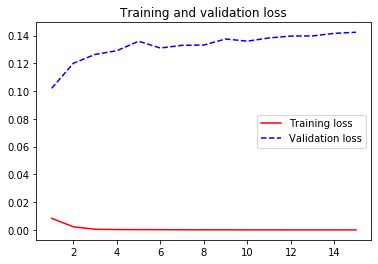

In [28]:
epochs = range(1, 16)
plt.figure()
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

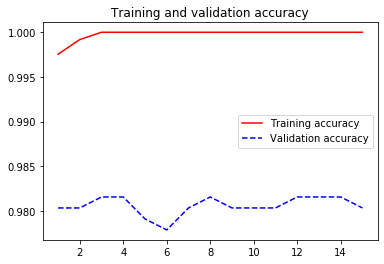

In [29]:
plt.figure()
plt.plot(epochs, history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b--', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [30]:
evaluate(model, x_test, y_test)

813/813 [==============================] - 1s 788us/step
--------------------------------------------------
Accuracy: 0.9803197979927063
Precision: 0.9420289855072463
Recall: 0.9420289855072463
F1-Score: 0.9420289855072463
Confusion Matrix:
[[667   8]
 [  8 130]]
